#Thermal Comfort Prediction

Energy consumption in buildings is due to lights, appliances and  air-conditioning. Besides attaining a healthy indoor environment, a prior knowledge about the occupant’s thermal comfort can be beneficial in reducing energy consumption, as it can save energy which is otherwise spent in extra cooling or heating purpose. On the other hand, inappropriate condition in buildings may cause sick building syndrome(SBS) which is a very common syndrom in buildings with inappropriate ventilation.

This project is a data-driven approach to predict individual thermal comfort using environmental and human factors as input.

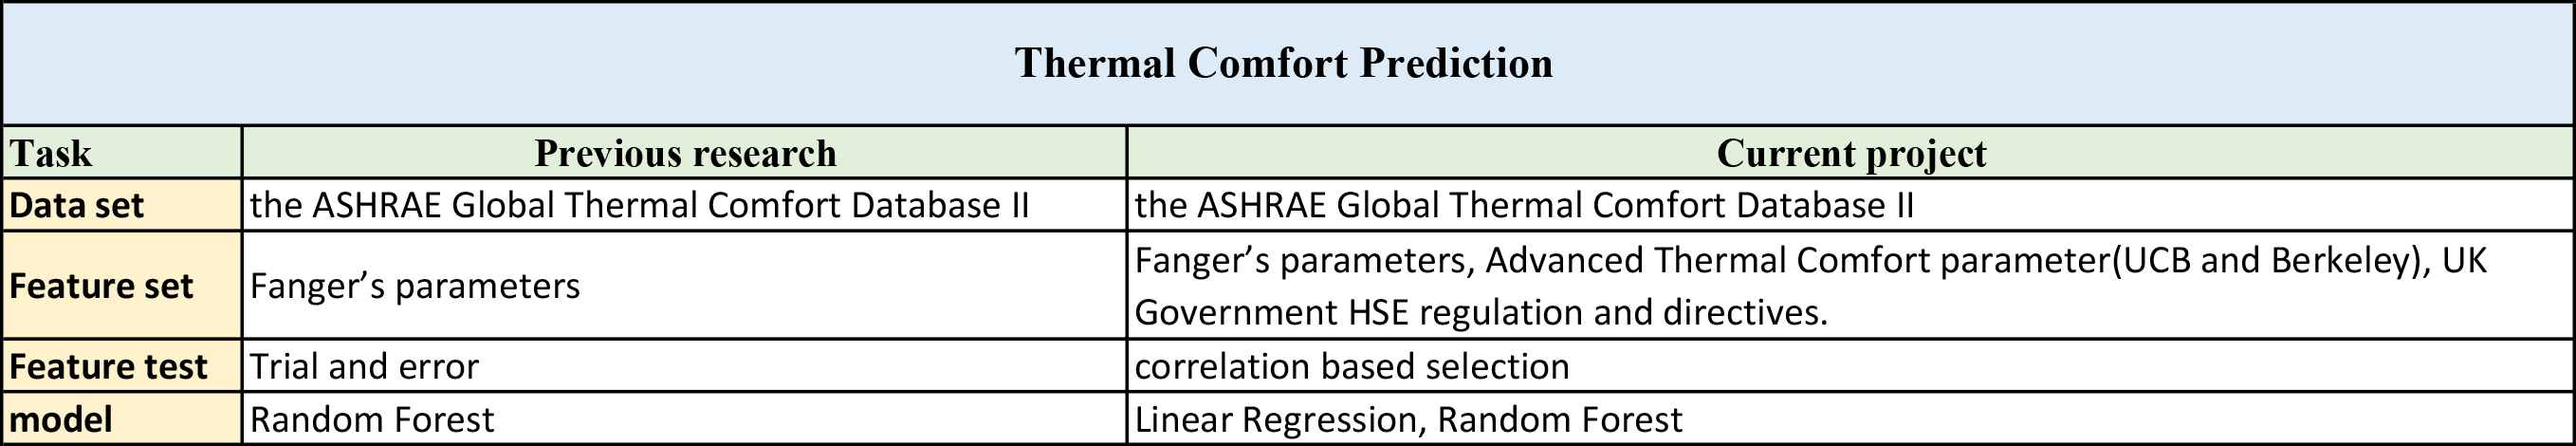

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import warnings
import time
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
linear_reg = linear_model.LinearRegression()
warnings.filterwarnings('ignore')


#Dataset importing and Data shaving

For this project,the database of thermal comfort which is publicly available as part of the ASHRAE RP-884 project is used:
https://datadryad.org/stash/dataset/doi:10.6078/D1F671

In [ ]:
DF_data_raw= pd.read_csv('....ashrae_db2.01 - Copy (2).csv',header=0,encoding='latin-1') #windows-1252

in this list we eliminate the column which contains text, the Farenhein values and also 'Blind (curtain)','Fan', 'Window', 'Door', 'Heater' values because for more than 95% of cases, the values were not defined

In [ ]:
DF_data_raw.columns

Index(['Publication (Citation)', 'Data contributor', 'Year', 'Season',
       'Koppen climate classification', 'Climate', 'City', 'Country',
       'Building type', 'Cooling startegy_building level',
       'Cooling startegy_operation mode for MM buildings',
       'Heating strategy_building level', 'Age', 'Sex', 'Thermal sensation',
       'Thermal sensation acceptability', 'Thermal preference',
       'Air movement acceptability', 'Air movement preference',
       'Thermal comfort', 'PMV', 'PPD', 'SET', 'Clo', 'Met', 'activity_10',
       'activity_20', 'activity_30', 'activity_60', 'Air temperature (C)',
       'Air temperature (F)', 'Ta_h (C)', 'Ta_h (F)', 'Ta_m (C)', 'Ta_m (F)',
       'Ta_l (C)', 'Ta_l (F)', 'Operative temperature (C)',
       'Operative temperature (F)', 'Radiant temperature (C)',
       'Radiant temperature (F)', 'Globe temperature (C)',
       'Globe temperature (F)', 'Tg_h (C)', 'Tg_h (F)', 'Tg_m (C)', 'Tg_m (F)',
       'Tg_l (C)', 'Tg_l (F)', 'Relative humi

In [ ]:
#Changing the season names to numbers to be able to evaluate them in correlation section.
mapping={'Summer': 0, 'Winter': 1, 'Spring': 2, 'Autumn': 3 }
DF_data_raw = DF_data_raw.replace({'Season' :mapping})

In [ ]:
select=['Year', 'Season',
        'Age', 'Thermal sensation','Thermal sensation acceptability', 'Air movement acceptability',
        'Thermal comfort', 'PMV', 'PPD', 'SET', 'Clo', 'Met', 'activity_10','activity_20', 'activity_30',
        'activity_60', 'Air temperature (C)','Ta_h (C)', 'Ta_m (C)','Ta_l (C)', 'Operative temperature (C)',
        'Radiant temperature (C)','Globe temperature (C)','Tg_h (C)', 'Tg_m (C)','Tg_l (C)', 'Relative humidity (%)',
        'Humidity sensation', 'Air velocity (m/s)','Velocity_l (m/s)','Subject«s height (cm)', 'Subject«s weight (kg)',
       'Outdoor monthly air temperature (C)','Velocity_h (m/s)', 'Velocity_m (m/s)']

In [ ]:
DF_data = DF_data_raw[select]

In [ ]:
DF_data

,Year,Season,Age,Thermal sensation,Thermal sensation acceptability,Air movement acceptability,Thermal comfort,PMV,PPD,SET,...,Tg_l (C),Relative humidity (%),Humidity sensation,Air velocity (m/s),Velocity_l (m/s),Subject«s height (cm),Subject«s weight (kg),Outdoor monthly air temperature (C),Velocity_h (m/s),Velocity_m (m/s)
0,2000.0,0.0,15.0,-0.5,1.0,1.0,5.0,NaN,NaN,NaN,...,NaN,50.2,NaN,0.06,NaN,162.0,NaN,25.0,NaN,NaN
1,2000.0,0.0,15.0,-2.1,1.0,1.0,5.0,NaN,NaN,NaN,...,NaN,50.2,NaN,0.06,NaN,154.0,NaN,25.0,NaN,NaN
2,2000.0,0.0,15.0,0.5,1.0,1.0,6.0,NaN,NaN,NaN,...,NaN,50.2,NaN,0.06,NaN,173.0,NaN,25.0,NaN,NaN
3,2000.0,0.0,14.0,-2.5,0.0,1.0,4.0,NaN,NaN,NaN,...,NaN,50.2,NaN,0.06,NaN,167.0,NaN,25.0,NaN,NaN
4,2000.0,0.0,15.0,-0.5,1.0,1.0,6.0,NaN,NaN,NaN,...,NaN,50.2,NaN,0.06,NaN,178.0,NaN,25.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107571,1996.0,1.0,17.0,-2.1,1.0,NaN,5.0,NaN,NaN,NaN,...,NaN,67.4,NaN,NaN,NaN,NaN,NaN,NaN,0.14,NaN
107572,1996.0,1.0,15.0,-0.5,1.0,NaN,5.0,NaN,NaN,NaN,...,NaN,67.4,NaN,NaN,NaN,NaN,NaN,NaN,0.14,NaN
107573,1996.0,1.0,16.0,-1.0,1.0,NaN,5.0,NaN,NaN,NaN,...,NaN,67.4,NaN,NaN,NaN,NaN,NaN,NaN,0.14,NaN
107574,1996.0,1.0,16.0,1.0,1.0,NaN,4.0,NaN,NaN,NaN,...,NaN,67.4,NaN,NaN,NaN,NaN,NaN,NaN,0.14,NaN


In [ ]:
DF_data.columns

Index(['Year', 'Season', 'Age', 'Thermal sensation',
       'Thermal sensation acceptability', 'Air movement acceptability',
       'Thermal comfort', 'PMV', 'PPD', 'SET', 'Clo', 'Met', 'activity_10',
       'activity_20', 'activity_30', 'activity_60', 'Air temperature (C)',
       'Ta_h (C)', 'Ta_m (C)', 'Ta_l (C)', 'Operative temperature (C)',
       'Radiant temperature (C)', 'Globe temperature (C)', 'Tg_h (C)',
       'Tg_m (C)', 'Tg_l (C)', 'Relative humidity (%)', 'Humidity sensation',
       'Air velocity (m/s)', 'Velocity_l (m/s)', 'Subject«s height (cm)',
       'Subject«s weight (kg)', 'Outdoor monthly air temperature (C)',
       'Velocity_h (m/s)', 'Velocity_m (m/s)'],
      dtype='object')

In [ ]:
DF_data = DF_data[DF_data['Thermal comfort'].notna()]
DF_data = DF_data.fillna(0)

In [ ]:
DF_data

,Year,Season,Age,Thermal sensation,Thermal sensation acceptability,Air movement acceptability,Thermal comfort,PMV,PPD,SET,...,Tg_l (C),Relative humidity (%),Humidity sensation,Air velocity (m/s),Velocity_l (m/s),Subject«s height (cm),Subject«s weight (kg),Outdoor monthly air temperature (C),Velocity_h (m/s),Velocity_m (m/s)
0,2000.0,0.0,15.0,-0.5,1.0,1.0,5.0,0.0,0.0,0.0,...,0.0,50.2,0.0,0.06,0.0,162.0,0.0,25.0,0.00,0.0
1,2000.0,0.0,15.0,-2.1,1.0,1.0,5.0,0.0,0.0,0.0,...,0.0,50.2,0.0,0.06,0.0,154.0,0.0,25.0,0.00,0.0
2,2000.0,0.0,15.0,0.5,1.0,1.0,6.0,0.0,0.0,0.0,...,0.0,50.2,0.0,0.06,0.0,173.0,0.0,25.0,0.00,0.0
3,2000.0,0.0,14.0,-2.5,0.0,1.0,4.0,0.0,0.0,0.0,...,0.0,50.2,0.0,0.06,0.0,167.0,0.0,25.0,0.00,0.0
4,2000.0,0.0,15.0,-0.5,1.0,1.0,6.0,0.0,0.0,0.0,...,0.0,50.2,0.0,0.06,0.0,178.0,0.0,25.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107571,1996.0,1.0,17.0,-2.1,1.0,0.0,5.0,0.0,0.0,0.0,...,0.0,67.4,0.0,0.00,0.0,0.0,0.0,0.0,0.14,0.0
107572,1996.0,1.0,15.0,-0.5,1.0,0.0,5.0,0.0,0.0,0.0,...,0.0,67.4,0.0,0.00,0.0,0.0,0.0,0.0,0.14,0.0
107573,1996.0,1.0,16.0,-1.0,1.0,0.0,5.0,0.0,0.0,0.0,...,0.0,67.4,0.0,0.00,0.0,0.0,0.0,0.0,0.14,0.0
107574,1996.0,1.0,16.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,...,0.0,67.4,0.0,0.00,0.0,0.0,0.0,0.0,0.14,0.0


In [ ]:
DF_data['Thermal comfort'].value_counts()

5.0    13325
6.0     6010
4.0     5918
3.0     4400
2.0     3404
3.5      699
1.0      602
2.7      438
4.3      362
4.5      271
5.2      240
3.4      208
1.8      147
2.6      116
5.1       90
1.7       58
1.5       26
0.9        4
2.5        3
4.2        2
2.4        1
2.3        1
2.2        1
1.3        1
2.8        1
Name: Thermal comfort, dtype: int64

In [ ]:
#DF_data['Thermal comfort'].plot(figsize=(8,8))

In [ ]:
#Testing to change it to some integers to use the accuracy
DF_data = DF_data[DF_data['Thermal comfort'] != 'Na']

DF_data['Thermal comfort'] = DF_data['Thermal comfort'].astype('int64')
DF_data['Thermal comfort'].value_counts(sort=False)

5    13655
6     6010
4     6553
1      834
3     5307
2     3965
0        4
Name: Thermal comfort, dtype: int64

#Dataset splitting

In [ ]:
#'DF_data' is before classifying but 'data' is after shaving
X = DF_data.drop(columns=['Thermal comfort']) #Feature
y = DF_data[['Thermal comfort']] #target
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.2,shuffle=False)
concat_DF=pd.concat((X_train_val,y_train_val),axis=1)

#Pearson Correlation

In [ ]:
def WAPE (y_true, y_pred):         #Weighted Absolute Percentage Error (WAPE)
    import numpy as np
    df_y_true=y_true.copy()
    df_y_pred=y_pred.copy()
    df_y_pred.columns=df_y_true.columns
    WAPE=100*np.sum(np.abs(df_y_pred - df_y_true))/np.sum(np.abs(df_y_true))
    return  round(WAPE[0],2)



def acc_timeseriessplit(X,y,model,cv):
  tscv = TimeSeriesSplit(n_splits=cv)
  acc = []
  for train_index, valid_index in tscv.split(X):
    #print("TRAIN:", len(train_index), "TEST:", len(valid_index))

    X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train, y_valid = y.iloc[train_index,:], y.iloc[valid_index,:]

    model.fit(X_train, y_train)
    y_valid_predicted=pd.DataFrame(index=y_valid.index)
    y_valid_predicted['pred'] = model.predict(X_valid)
    #y_valid_predicted = y_valid_predicted.reshape(len(y_valid_predicted),1)
    accuracy =WAPE(y_valid,y_valid_predicted)
    acc.append(accuracy)
  return np.average(acc)

def plot_y_feat (WAPE_features , plt_name = 'Name [-]' ):
  import matplotlib as mpl
  import matplotlib.pyplot as plt
  import matplotlib.path as mpath
  import numpy as np

  plt.figure(1,figsize=(15,6))
  plt.style.use('seaborn-whitegrid')
  plt.axis ('auto')
  plt.plot(np.arange(len(WAPE_features.index)), np.array(WAPE_features), color = 'blue',  markersize = 5, linestyle = '-')
  plt.xticks(np.arange(len(WAPE_features.index)),WAPE_features.index, rotation=40, fontsize=8,horizontalalignment="right", wrap=True)
  plt.ylabel('WAPE [%]', wrap=True)
  fig = plt.figure(1)
  fig.canvas.set_window_title(plt_name)

##Step one

In [ ]:
corr_gen

Thermal sensation acceptability        0.311324
Subject«s height (cm)                  0.264320
Subject«s weight (kg)                  0.260798
Tg_h (C)                               0.239841
Age                                    0.205531
SET                                    0.132414
Thermal sensation                      0.130502
Radiant temperature (C)                0.128656
Air movement acceptability             0.113788
Clo                                    0.107116
activity_20                            0.087643
activity_60                            0.083734
Ta_h (C)                               0.077376
Globe temperature (C)                  0.068841
Relative humidity (%)                  0.062905
Operative temperature (C)              0.062262
Velocity_m (m/s)                       0.056451
Year                                   0.046738
Met                                    0.044789
Air velocity (m/s)                     0.039106
activity_10                            0

In [ ]:
FeatureSelection #.sort_values(ascending=False)

Thermal sensation acceptability        28.366
Subject«s height (cm)                  27.268
Subject«s weight (kg)                  28.098
Tg_h (C)                               26.456
Age                                    27.370
SET                                    26.248
Thermal sensation                      26.084
Radiant temperature (C)                27.838
Air movement acceptability             27.274
Clo                                    27.400
activity_20                            28.656
activity_60                            27.482
Ta_h (C)                               28.824
Globe temperature (C)                  27.926
Relative humidity (%)                  27.494
Operative temperature (C)              27.928
Velocity_m (m/s)                       26.972
Year                                   27.648
Met                                    27.840
Air velocity (m/s)                     28.294
activity_10                            27.736
Velocity_l (m/s)                  

In [ ]:
 #choose the set of features which leads to minimum WAPE
FeatureSelection_selected = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]

In [ ]:
FeatureSelection_selected

Thermal sensation acceptability    28.366
Subject«s height (cm)              27.268
Subject«s weight (kg)              28.098
Tg_h (C)                           26.456
Age                                27.370
SET                                26.248
Thermal sensation                  26.084
dtype: float64

In [ ]:
FeatureSelection_neg_after

Air movement acceptability             27.274
activity_60                            27.482
Globe temperature (C)                  27.926
Relative humidity (%)                  27.494
Velocity_m (m/s)                       26.972
activity_10                            27.736
Air temperature (C)                    28.832
Outdoor monthly air temperature (C)    28.472
Season                                 27.878
Tg_l (C)                               27.828
dtype: float64

In [ ]:
#the remaining ones are sorted in a descending order based on the overall error obtained while adding them.
#FeatureSelection_selected = pd.concat((FeatureSelection_neg_after.sort_values(ascending=False),FeatureSelection_selected.sort_values(ascending=False)), axis = 0)

AttributeError: ignored

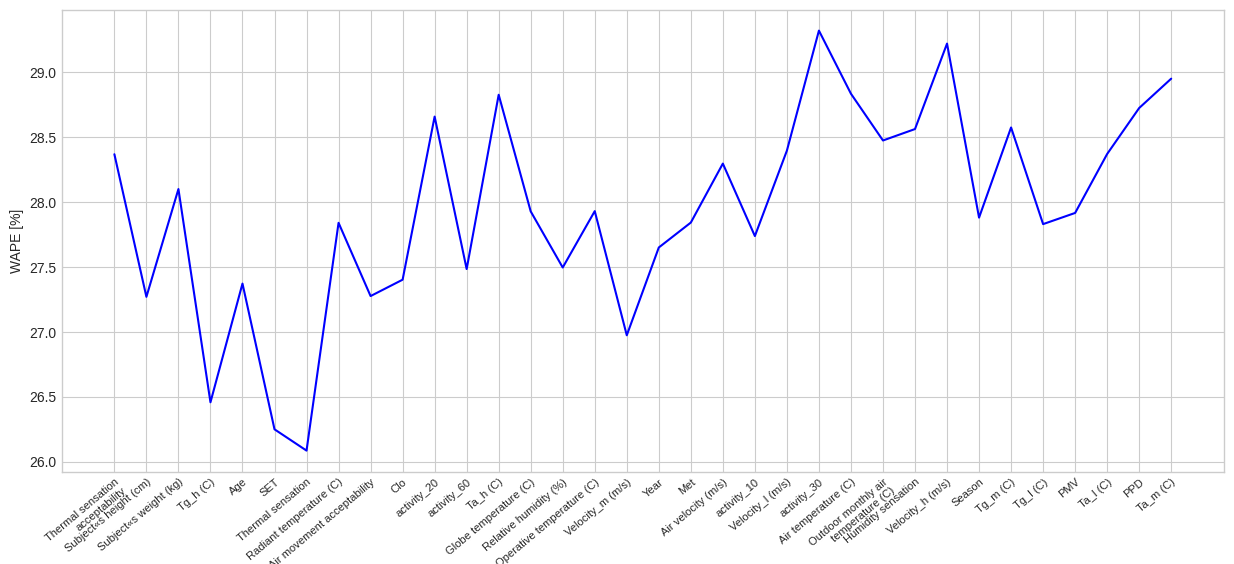

In [ ]:
#Plot and save the figure
Save_address = '/content/drive/MyDrive/Building /Project 3'
plt_name ='selected_features_step1_unsort'+'.png'
plot_y_feat(FeatureSelection , plt_name = plt_name)
plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))
warnings.filterwarnings("ignore")
plt.close()

In [ ]:
plot_y_feat(FeatureSelection , plt_name = plt_name)

##Step two

In [ ]:
DF_features_selected = Features[FeatureSelection.index]
#reverse the order of columns
DF_features_selected=DF_features_selected.iloc[:, ::-1]

In [ ]:
#same as previous step features are added gradually and the obtained WAPE is monitored
#Selecting the set of features which leads to minmum WAPE

In [ ]:
FeatureSelection_selected_updated

Ta_m (C)                               29.454
PPD                                    29.160
Ta_l (C)                               30.496
PMV                                    30.660
Tg_l (C)                               30.224
Tg_m (C)                               29.646
Season                                 30.208
Velocity_h (m/s)                       30.022
Humidity sensation                     29.950
Outdoor monthly air temperature (C)    29.262
Air temperature (C)                    30.356
activity_30                            30.954
Velocity_l (m/s)                       30.192
activity_10                            30.752
Air velocity (m/s)                     32.852
Met                                    31.946
Year                                   31.416
Velocity_m (m/s)                       31.204
Operative temperature (C)              32.778
Relative humidity (%)                  33.644
Globe temperature (C)                  33.388
Ta_h (C)                          

In [ ]:
#Plot and save the figure
plt_name ='selected_features_step2_unsort'+'.png'
plot_y_feat(FeatureSelection , plt_name = plt_name)
plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))
plt.close()
warnings.filterwarnings("ignore")

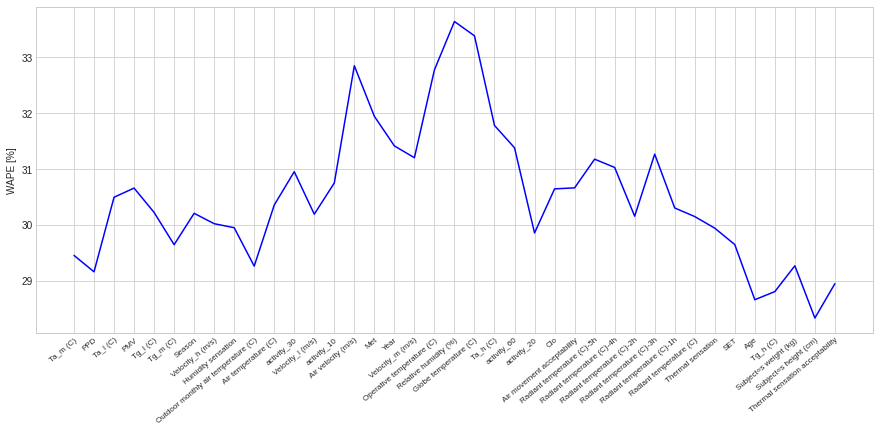

In [ ]:
plot_y_feat(FeatureSelection , plt_name = plt_name)

##Step three


In [ ]:
FeatureSelection_final

Outdoor monthly air temperature (C)    27.600
Thermal sensation                      26.038
Humidity sensation                     25.168
Subject«s weight (kg)                  25.012
Air movement acceptability             24.718
Ta_m (C)                               24.742
Year                                   25.092
Subject«s height (cm)                  24.340
Season                                 24.414
Tg_m (C)                               24.606
Met                                    24.432
activity_20                            25.078
Radiant temperature (C)-5h             24.438
activity_10                            24.330
Velocity_l (m/s)                       24.624
Ta_l (C)                               24.848
Radiant temperature (C)-3h             24.792
Radiant temperature (C)                24.948
Radiant temperature (C)-1h             24.612
Radiant temperature (C)-2h             24.612
Tg_h (C)                               24.658
Radiant temperature (C)-4h        

In [ ]:
FeatureSelection_final.index

Index(['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)'],
      dtype='object')

In [ ]:
#Plot and save the figure
plt_name ='selected_features_step3_unsort'+'.png'
plot_y_feat(Final_WAPE_results)
plt.savefig(os.path.join(Save_address,plt_name), dpi = (400))
plt.close()
warnings.filterwarnings("ignore")



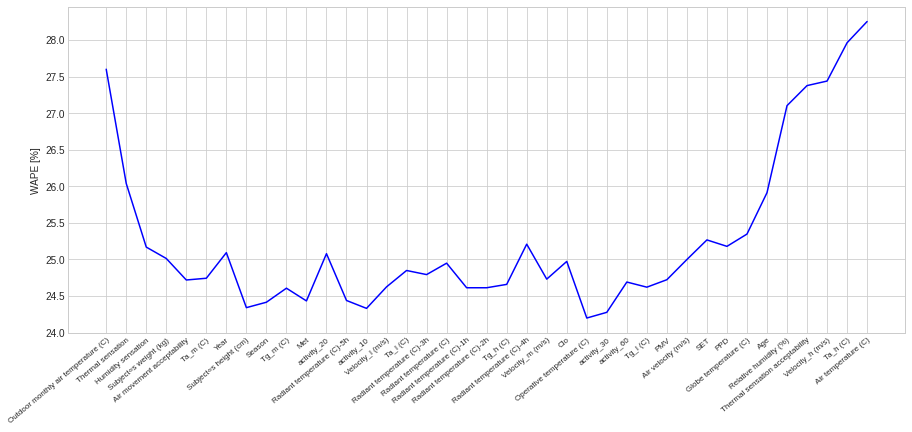

In [ ]:
plot_y_feat(Final_WAPE_results)

#Prediction

In [ ]:
List = ['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)']



'X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.2,shuffle=False)\nconcat_DF=pd.concat((X_train_val,y_train_val),axis=1)'

##Random Forest

In [ ]:
def accuracy(X,y,model,cv):
  tscv = TimeSeriesSplit(n_splits=cv)
  for train_index, valid_index in tscv.split(X):
    #print("TRAIN:", len(train_index), "TEST:", len(valid_index))

    X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train, y_valid = y.iloc[train_index,:], y.iloc[valid_index,:]

    model.fit(X_train, y_train)
    y_valid_predicted=pd.DataFrame(index=y_valid.index)
    y_valid_predicted['pred'] = model.predict(X_valid)
    #y_valid_predicted = y_valid_predicted.reshape(len(y_valid_predicted),1)
    accuracy =  (accuracy_score(y_valid,y_valid_predicted)*100)
  return print(f'accuracy: {accuracy}%')

In [ ]:
# put the selected features led to min. WAP to feature text DF in order to find the best prediction

RF_class= RandomForestClassifier(n_estimators = 100)
ThermalComfort_predict_RF = cross_val_predict(RF_class,X3,y3,cv=100)

print('accuracy score: %.1f' %(accuracy_score(y3,ThermalComfort_predict_RF)*100))
confusion_matrix(y3,ThermalComfort_predict_RF)

accuracy score: 34.2


array([[   0,    3,    1,    0,    0,    0,    0],
       [   2,   80,  183,  141,   53,  121,  254],
       [   0,  101, 1363,  809,  322,  891,  479],
       [   0,   64,  537, 1067,  929, 1746,  964],
       [   0,   28,  222,  840, 1394, 3112,  957],
       [   0,   50,  755, 1476, 2856, 5666, 2852],
       [   0,   11,   14,  173,  373, 2591, 2848]])

In [ ]:
features1 = ['Air temperature (C)', 'Air velocity (m/s)', 'Relative humidity (%)', 'Clo', 'Met'] #previous study
X1=DF_data[features1]
y1=DF_data[['Thermal comfort']]

X_train_val1,X_test1,y_train_val1,y_test1=train_test_split(X1,y1,test_size=0.2,shuffle=False)
RF_class= RandomForestClassifier(n_estimators = 100)
RF_class.fit(X_train_val1,y_train_val1)
predict1 = RF_class.predict(X_test1)

print('accuracy score: %.1f' %(accuracy_score(y_test1,predict1)*100))
confusion_matrix(y_test1,predict1)

accuracy score: 28.4


array([[   3,    1,   35,   17,   24,    2],
       [   0,    6,  143,   32,  111,   14],
       [   0,   22,  479,  138,  387,   70],
       [   0,   38,  786,  207,  467,   50],
       [   7,   66, 1225,  389, 1284,  174],
       [   3,   28,  271,  111,  592,   84]])

In [ ]:
features_This_study = ['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)']

X3=DF_data[features_This_study]
y3=DF_data[['Thermal comfort']]

X_train_val3,X_test3,y_train_val3,y_test3=train_test_split(X3,y3,test_size=0.2,shuffle=False)
RF_class= RandomForestClassifier(n_estimators = 100)
RF_class.fit(X_train_val3,y_train_val3)
predict3 = RF_class.predict(X_test3)

print('accuracy score: %.1f' %(accuracy_score(y_test3,predict3)*100))
confusion_matrix(y_test3,predict3)

accuracy score: 39.9


array([[   1,   24,   15,   15,   27,    0],
       [   0,   55,   73,   58,  115,    5],
       [   0,   86,  205,  226,  561,   18],
       [   0,   82,  138,  323,  956,   49],
       [   0,  144,  203,  426, 2210,  162],
       [   0,   24,   49,   66,  845,  105]])

In [ ]:
DF_features_This_study = DF_data[['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)']]
X4 = DF_features_This_study
y = DF_data[['Thermal comfort']]
prediction_algorithm = RandomForestClassifier(n_estimators = 100)
accuracy(X4,y,prediction_algorithm, 50)

accuracy: 35.39325842696629%


##Extra trees Classifier

In [ ]:
features_This_study = ['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)']

X5=DF_data[features_This_study]
y5=DF_data[['Thermal comfort']]

X_train_val5,X_test5,y_train_val5,y_test5=train_test_split(X5,y5,test_size=0.2,shuffle=False)
RF_class= ExtraTreesClassifier(n_estimators = 100)
RF_class.fit(X_train_val5,y_train_val5)
predict5 = RF_class.predict(X_test5)

print('accuracy score: %.1f' %(accuracy_score(y_test5,predict5)*100))
confusion_matrix(y_test5,predict5)

accuracy score: 39.7


array([[   4,    9,   15,    9,   44,    1],
       [   2,   20,  100,   25,  155,    4],
       [   0,   42,  278,   70,  678,   28],
       [   0,   38,  195,   75, 1185,   55],
       [   0,   69,  365,  133, 2375,  203],
       [   0,   10,   97,   47,  804,  131]])

In [ ]:
DF_features_This_study = DF_data[['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)']]
X6 = DF_features_This_study
y = DF_data[['Thermal comfort']]
prediction_algorithm = ExtraTreesClassifier(n_estimators = 100)
accuracy(X6,y,prediction_algorithm, 100)

accuracy: 35.93314763231198%


##KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)

In [ ]:
features_This_study = ['Outdoor monthly air temperature (C)', 'Thermal sensation',
       'Humidity sensation', 'Subject«s weight (kg)',
       'Air movement acceptability', 'Ta_m (C)', 'Year',
       'Subject«s height (cm)', 'Season', 'Tg_m (C)', 'Met', 'activity_20',
       'Radiant temperature (C)-5h', 'activity_10', 'Velocity_l (m/s)',
       'Ta_l (C)', 'Radiant temperature (C)-3h', 'Radiant temperature (C)',
       'Radiant temperature (C)-1h', 'Radiant temperature (C)-2h', 'Tg_h (C)',
       'Radiant temperature (C)-4h', 'Velocity_m (m/s)', 'Clo',
       'Operative temperature (C)']

X7=DF_data[features_This_study]
y7=DF_data[['Thermal comfort']]

X_train_val7,X_test7,y_train_val7,y_test7=train_test_split(X7,y7,test_size=0.2,shuffle=False,random_state=1234)
knn_model.fit(X_train_val7,y_train_val7)
predict7 = knn_model.predict(X_test7)
#print('accuracy score: %.1f' %(accuracy_score(y_test7,predict7)*100))
mse = mean_squared_error(y_test7,predict7)
rmse = sqrt(mse)
print(f'rmse: {round(rmse,3)}')

rmse: 1.212


In [ ]:
features8= ['Air temperature (C)', 'Air velocity (m/s)', 'Relative humidity (%)', 'Clo', 'Met']

X8=DF_data[features8]
y8=DF_data[['Thermal comfort']]

X_train_val8,X_test8,y_train_val8,y_test8=train_test_split(X8,y8,test_size=0.2,shuffle=False,random_state=1234)
knn_model.fit(X_train_val8,y_train_val8)
predict8 = knn_model.predict(X_test8)
#print('accuracy score: %.1f' %(accuracy_score(y_test7,predict7)*100))
mse = mean_squared_error(y_test8,predict8)
rmse = sqrt(mse)
print(f'rmse: {round(rmse,3)}')

rmse: 1.572
